In [ ]:
using Revise, Genie, StatsBase, Statistics, JLD2, DCAUtils


res_all = [];

dbd_msa  = read_fasta_alignment("../Gen.jl/data/alignments/natural/DBD_alignment.uniref90.cov80.a2m", 0.9);
@load "../data_Genie/pars_dbd.jld2"


N_steps = 3*10^6; N_chains = 500; N_start_seq = 200; NN_points = 500; steps = unique([
        trunc(Int,10^y) for y in range(log10(1), log10(N_steps), 
                length=NN_points)]); N_points = length(steps); hams_all = zeros(N_start_seq, N_points, N_chains); w = compute_weights(dbd_msa,
    22, 0.2)[1]; idx_seqs = sample(collect(1:size(dbd_msa,2)), ProbabilityWeights(w), 
    N_start_seq); start_seq = [dbd_msa[:, idx_seqs[i]] for i in 1:N_start_seq]; w_seqs = w[idx_seqs];

J_dbd = zeros(21,76, 21,76);

@time for n in 1:N_start_seq
    res = run_potts(Int8.(hcat([start_seq[n] for i in 1:N_chains]...)), 
        h_dbd, 
        J_dbd, 
        temp = 1.0, 
        N_points = NN_points, 
        N_steps = N_steps);
    if n%10 == 0
        println("Initial seq $(n)")
    end
    push!(res_all, res) 
    #hams_all[n,:,:] .= ham_dist(res.step_msa)
end

start_msa = hcat([res_all[i].step_msa[1][:,1] for i in 1:N_start_seq]...);

w_seqs = zeros(N_start_seq);
for n in 1:N_start_seq
    ds = ham_dist(start_msa[:,n], dbd_msa)
    w_seqs[n] = w[findfirst(ds .== 0)]
end  

for n in 1:N_start_seq
    hams_all[n,:,:] .= ham_dist(res_all[n].step_msa)
end
    
hams_single = zeros(N_start_seq, N_points); chi_dyn_single = zeros(N_start_seq, N_points);
for i in 1:N_start_seq
    for n in 1:N_points
        hams_single[i,n] = mean(ham_dist(res_all[i].step_msa[1], res_all[i].step_msa[n]))
        chi_dyn_single[i,n] = var(ham_dist(res_all[i].step_msa[1], res_all[i].step_msa[n]))
    end
end


close("all")
plt.plot()
for i in 1:5
    plt.plot(steps, hams_single[i,:],label = "seq $(idx_seqs[i])")
end


plt.legend()
plt.xlabel("MCMC steps")
plt.xscale("log")
plt.ylabel("[H_A]")
plt.savefig("../single_wt_mean_ham_dist.png")
        

close("all")
plt.plot()
for i in 1:N_start_seq
    plt.plot(steps, chi_dyn_single[i,:], alpha = 0.05, color = "grey")
end

plt.plot(steps, mean(chi_dyn_single, Weights(w_seqs), dims = 1)[1,:], linewidth = 2.0, color = "black", label = "chi_dyn")

plt.legend()
plt.xlabel("MCMC steps")
plt.xscale("log")
plt.ylabel("chi_dyn_A")
plt.savefig("../single_wt_chi_dyn.png")


hams_single_all = mean(hams_all,dims = 3)[:,:,1]; mean_hams_single_all = mean(hams_single_all, Weights(w_seqs), dims = 1)[1,:];

close("all")
plt.plot()
for i in 1:N_start_seq
    plt.plot(steps, hams_single_all[i,:], alpha = 0.2, color = "grey")
end

plt.plot(steps, mean_hams_single_all, linewidth = 2.0, color = "black", label = "<[H_A]>")


plt.legend()
plt.xlabel("MCMC steps")
plt.xscale("log")
plt.ylabel("[H_A]")
plt.savefig("../all_single_wt_mean_ham_dist.png")
    


hams0 = mean(hams_all,dims = 3)[:,:,1]; first_part = mean(hams0 .^2, Weights(w_seqs), dims = 1)[1,:];
second_part  = (mean(hams0, Weights(w_seqs), dims = 1)[1,:]) .^2; chi_back = first_part - second_part;

hams0_tot = mean(hams_all .^2 ,dims = 3)[:,:,1]; first_part_tot = mean(hams0_tot, Weights(w_seqs), dims = 1)[1,:];
chi_tot = first_part_tot - second_part; 




chi_dyn = mean(chi_dyn_single, Weights(w_seqs), dims = 1)[1,:];

close("all")

plt.plot(res_all[1].steps, chi_dyn, color = "red", label = "chi_dyn")
plt.plot(res_all[1].steps, chi_back, color = "blue", label = "chi_back")
plt.plot(res_all[1].steps, chi_tot, color = "black", label = "chi_tot")

plt.legend()
plt.xscale("log")
plt.xlabel("MCMC steps")

savefig("../suscept_dbd_weight.png")
sum(abs2, chi_tot - chi_dyn - chi_back)



In [2]:
using PyPlot, JLD2
@load "../../data_Genie/cdes_dbd.jld2"

3-element Vector{Symbol}:
 :cdes
 :cde1
 :cde2

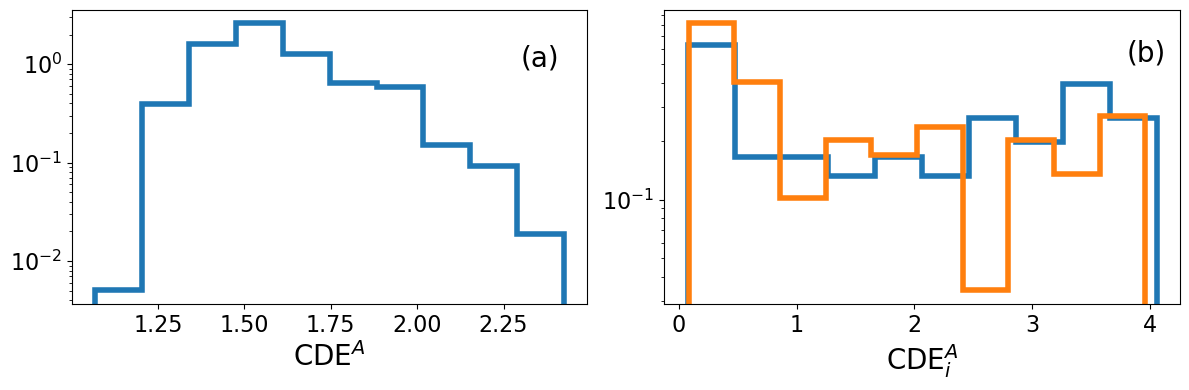

In [42]:
fig, axs = subplots(1, 2, figsize=(12, 4))

axs[1].hist(cdes, histtype="step", density=true, linewidth=4.0)
axs[1].set_yscale("log")
axs[1].set_xlabel("CDE\$^{A}\$", fontsize=20)
axs[1].tick_params(axis="both", labelsize=16)
axs[1].text(2.3, 0.95, "(a)",fontsize=20)

axs[2].hist(cde1, histtype="step", density=true, linewidth=4.0)
axs[2].set_yscale("log")
axs[2].set_xlabel("CDE\$^{A}_i\$", fontsize=20)
axs[2].tick_params(axis="both", labelsize=16)
axs[2].text(3.8, 0.52, "(b)",fontsize=20)
axs[2].hist(cde2, histtype="step", density=true, linewidth=4.0)
tight_layout()
savefig("../../cdes_DBD.pdf", dpi = 300)

